# `EmissionModel` Tutorial

Trey V. Wenger (c) March 2025

Here we demonstrate the basic features of the `EmissionModel` model. `EmissionModel` models 21-cm emission spectra like those obtained from typical ON - OFF observations.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.21.1
arviz version: 0.22.0dev
bayes_spec version: 1.7.5
caribou_hi version: 1.3.1a0+1.g7fcf136.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `EmissionModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"emission"`.

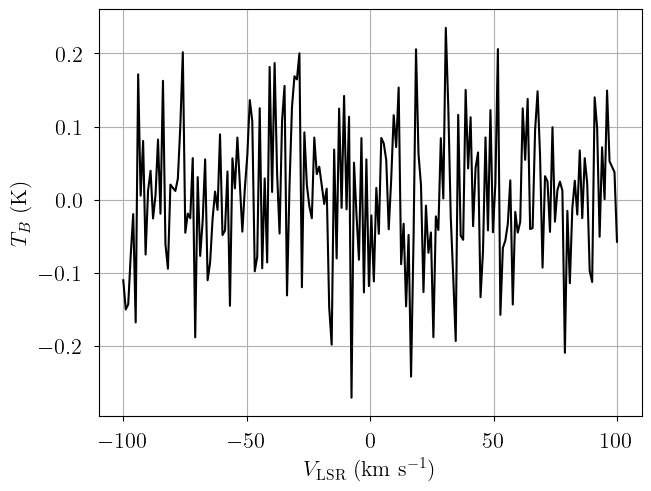

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-100.0, 100.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.1 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms * np.random.randn(len(velo_axis))

dummy_data = {"emission": SpecData(
    velo_axis,
    emission,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$T_B$ (K)",
)}

# Plot dummy data
fig, ax = plt.subplots(layout="constrained")
ax.plot(dummy_data["emission"].spectral, dummy_data["emission"].brightness, "k-")
ax.set_xlabel(dummy_data["emission"].xlabel)
_ = ax.set_ylabel(dummy_data["emission"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model. First we create the model.

In [3]:
from caribou_hi import EmissionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 10.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_nth_fwhm_1pc=[0.2, 0.1],  # log10(non-thermal FWHM at 1 pc) prior mean and width (km s-1)
    prior_depth_nth_fwhm_power=[0.3, 0.1],  # non-thermal FWHM vs. depth power law index prior mean and width
    prior_fwhm_L=None,  # Assume Gaussian line profile
    prior_baseline_coeffs=None,  # Default baseline priors
    ordered=False,  # do not assume optically-thin
    hyper_depth_linewidth=False,  # do not assume shared size-linewidth relationship
)
model.add_likelihood()

Now we simulate with a given set of simulation parameters.

In [4]:
# Simulation parameters
sim_params = {
    "log10_NHI": np.array([20.5, 20.25, 21.0]),
    "log10_depth": np.array([0.5, 1.5, 2.5]),
    "log10_pressure": np.array([3.25, 3.0, 3.75]),
    "velocity": np.array([-4.0, 0.0, 15.5]),
    "log10_n_alpha": -6.5,
    "log10_nth_fwhm_1pc": [0.2, 0.3, 0.4],
    "depth_nth_fwhm_power": [0.2, 0.4, 0.3],
    "baseline_emission_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
emission = model.model["emission"].eval(sim_params, on_unused_input="ignore")
data = {"emission": SpecData(
    velo_axis,
    emission,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"$T_B$ (K)",
)}

In [5]:
sim_params

{'log10_NHI': array([20.5 , 20.25, 21.  ]),
 'log10_depth': array([0.5, 1.5, 2.5]),
 'log10_pressure': array([3.25, 3.  , 3.75]),
 'velocity': array([-4. ,  0. , 15.5]),
 'log10_n_alpha': -6.5,
 'log10_nth_fwhm_1pc': [0.2, 0.3, 0.4],
 'depth_nth_fwhm_power': [0.2, 0.4, 0.3],
 'baseline_emission_norm': [0.0],
 'log10_nHI': array([1.51065, 0.26065, 0.01065]),
 'log10_tkin': array([1.69795731, 2.69795731, 3.69795731]),
 'tspin': array([  49.85322746,  486.56739315, 3719.31183091]),
 'fwhm_thermal': array([ 1.510739  ,  4.7773762 , 15.10739004]),
 'fwhm_nonthermal': array([ 1.99526231,  7.94328235, 14.12537545]),
 'fwhm': array([ 2.50267937,  9.26925336, 20.68234671])}

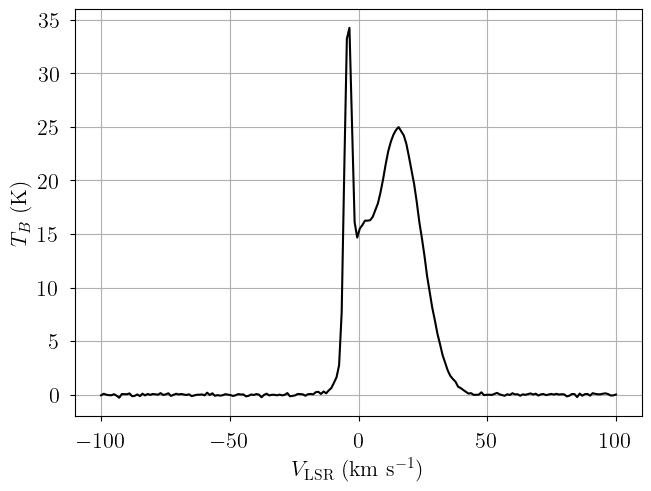

In [6]:
# Plot data
fig, ax = plt.subplots(layout="constrained")
ax.plot(data["emission"].spectral, data["emission"].brightness, "k-")
ax.set_xlabel(data["emission"].xlabel)
_ = ax.set_ylabel(data["emission"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `EmissionModel`. Here we create a new model with the simulated data. Note that models generally fail to converge when `hyper_depth_linewidth=False` since it introduces degeneracies, so we set it True here. This imposes a bias on the results.

In [7]:
# Initialize and define the model
model = EmissionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 10.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_nth_fwhm_1pc=[0.2, 0.1],  # log10(non-thermal FWHM at 1 pc) prior mean and width (km s-1)
    prior_depth_nth_fwhm_power=[0.3, 0.1],  # non-thermal FWHM vs. depth power law index prior mean and width
    prior_fwhm_L=None,  # Assume Gaussian line profile
    prior_baseline_coeffs=None,  # Default baseline priors
    ordered=False,  # do not assume optically-thin
    hyper_depth_linewidth=False,  # assume shared size-linewidth relationship
)
model.add_likelihood()

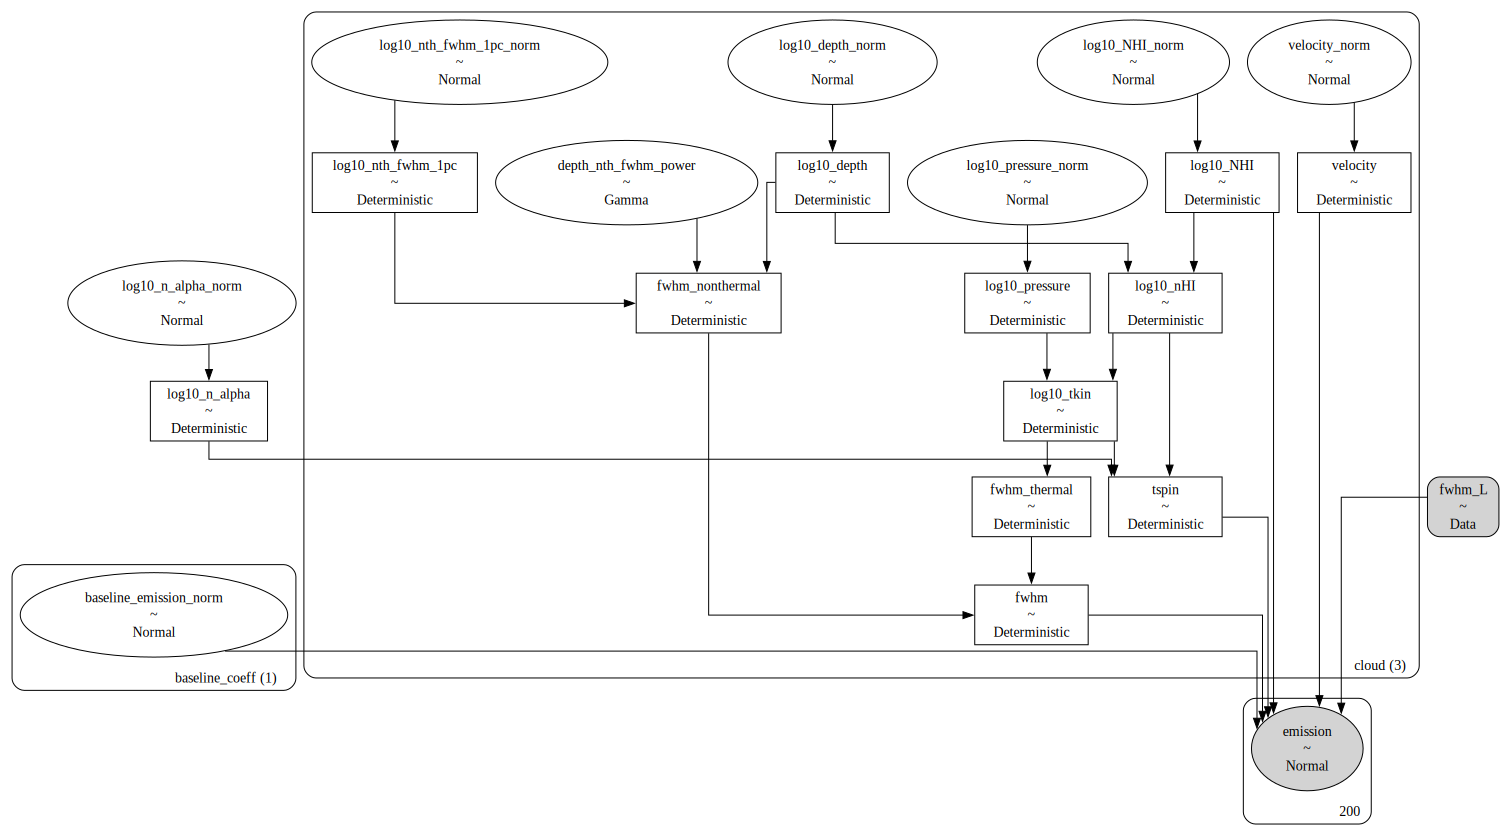

In [8]:
# Plot model graph
model.graph().render('emission_model', format='png')
model.graph()

In [9]:
# model string representation
print(model.model.str_repr())

 baseline_emission_norm ~ Normal(0, 1)
         log10_NHI_norm ~ Normal(0, 1)
       log10_depth_norm ~ Normal(0, 1)
    log10_pressure_norm ~ Normal(0, 1)
          velocity_norm ~ Normal(0, 1)
     log10_n_alpha_norm ~ Normal(0, 1)
log10_nth_fwhm_1pc_norm ~ Normal(0, 1)
   depth_nth_fwhm_power ~ Gamma(9, f())
              log10_NHI ~ Deterministic(f(log10_NHI_norm))
            log10_depth ~ Deterministic(f(log10_depth_norm))
         log10_pressure ~ Deterministic(f(log10_pressure_norm))
               velocity ~ Deterministic(f(velocity_norm))
          log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
     log10_nth_fwhm_1pc ~ Deterministic(f(log10_nth_fwhm_1pc_norm))
              log10_nHI ~ Deterministic(f(log10_depth_norm, log10_NHI_norm))
             log10_tkin ~ Deterministic(f(log10_pressure_norm, log10_depth_norm, log10_NHI_norm))
                  tspin ~ Deterministic(f(log10_n_alpha_norm, log10_pressure_norm, log10_depth_norm, log10_NHI_norm))
           fwhm_therm

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [baseline_emission_norm, depth_nth_fwhm_power, emission, log10_NHI_norm, log10_depth_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, log10_pressure_norm, velocity_norm]


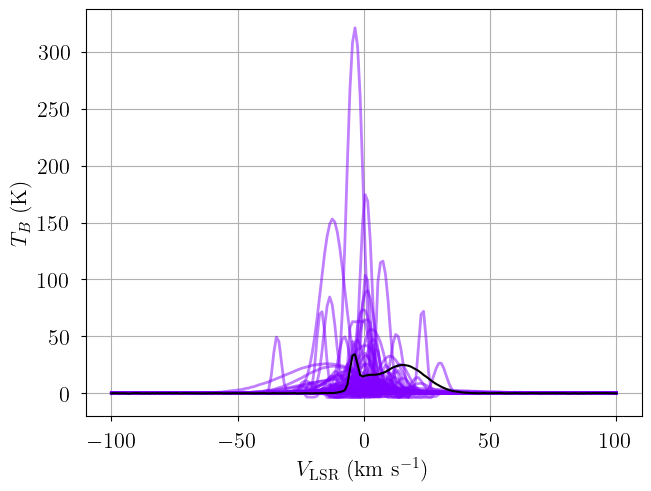

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

We can also check out our prior distributions impact the deterministic (derived) quantities in our model. The red points represent the simulation parameters.

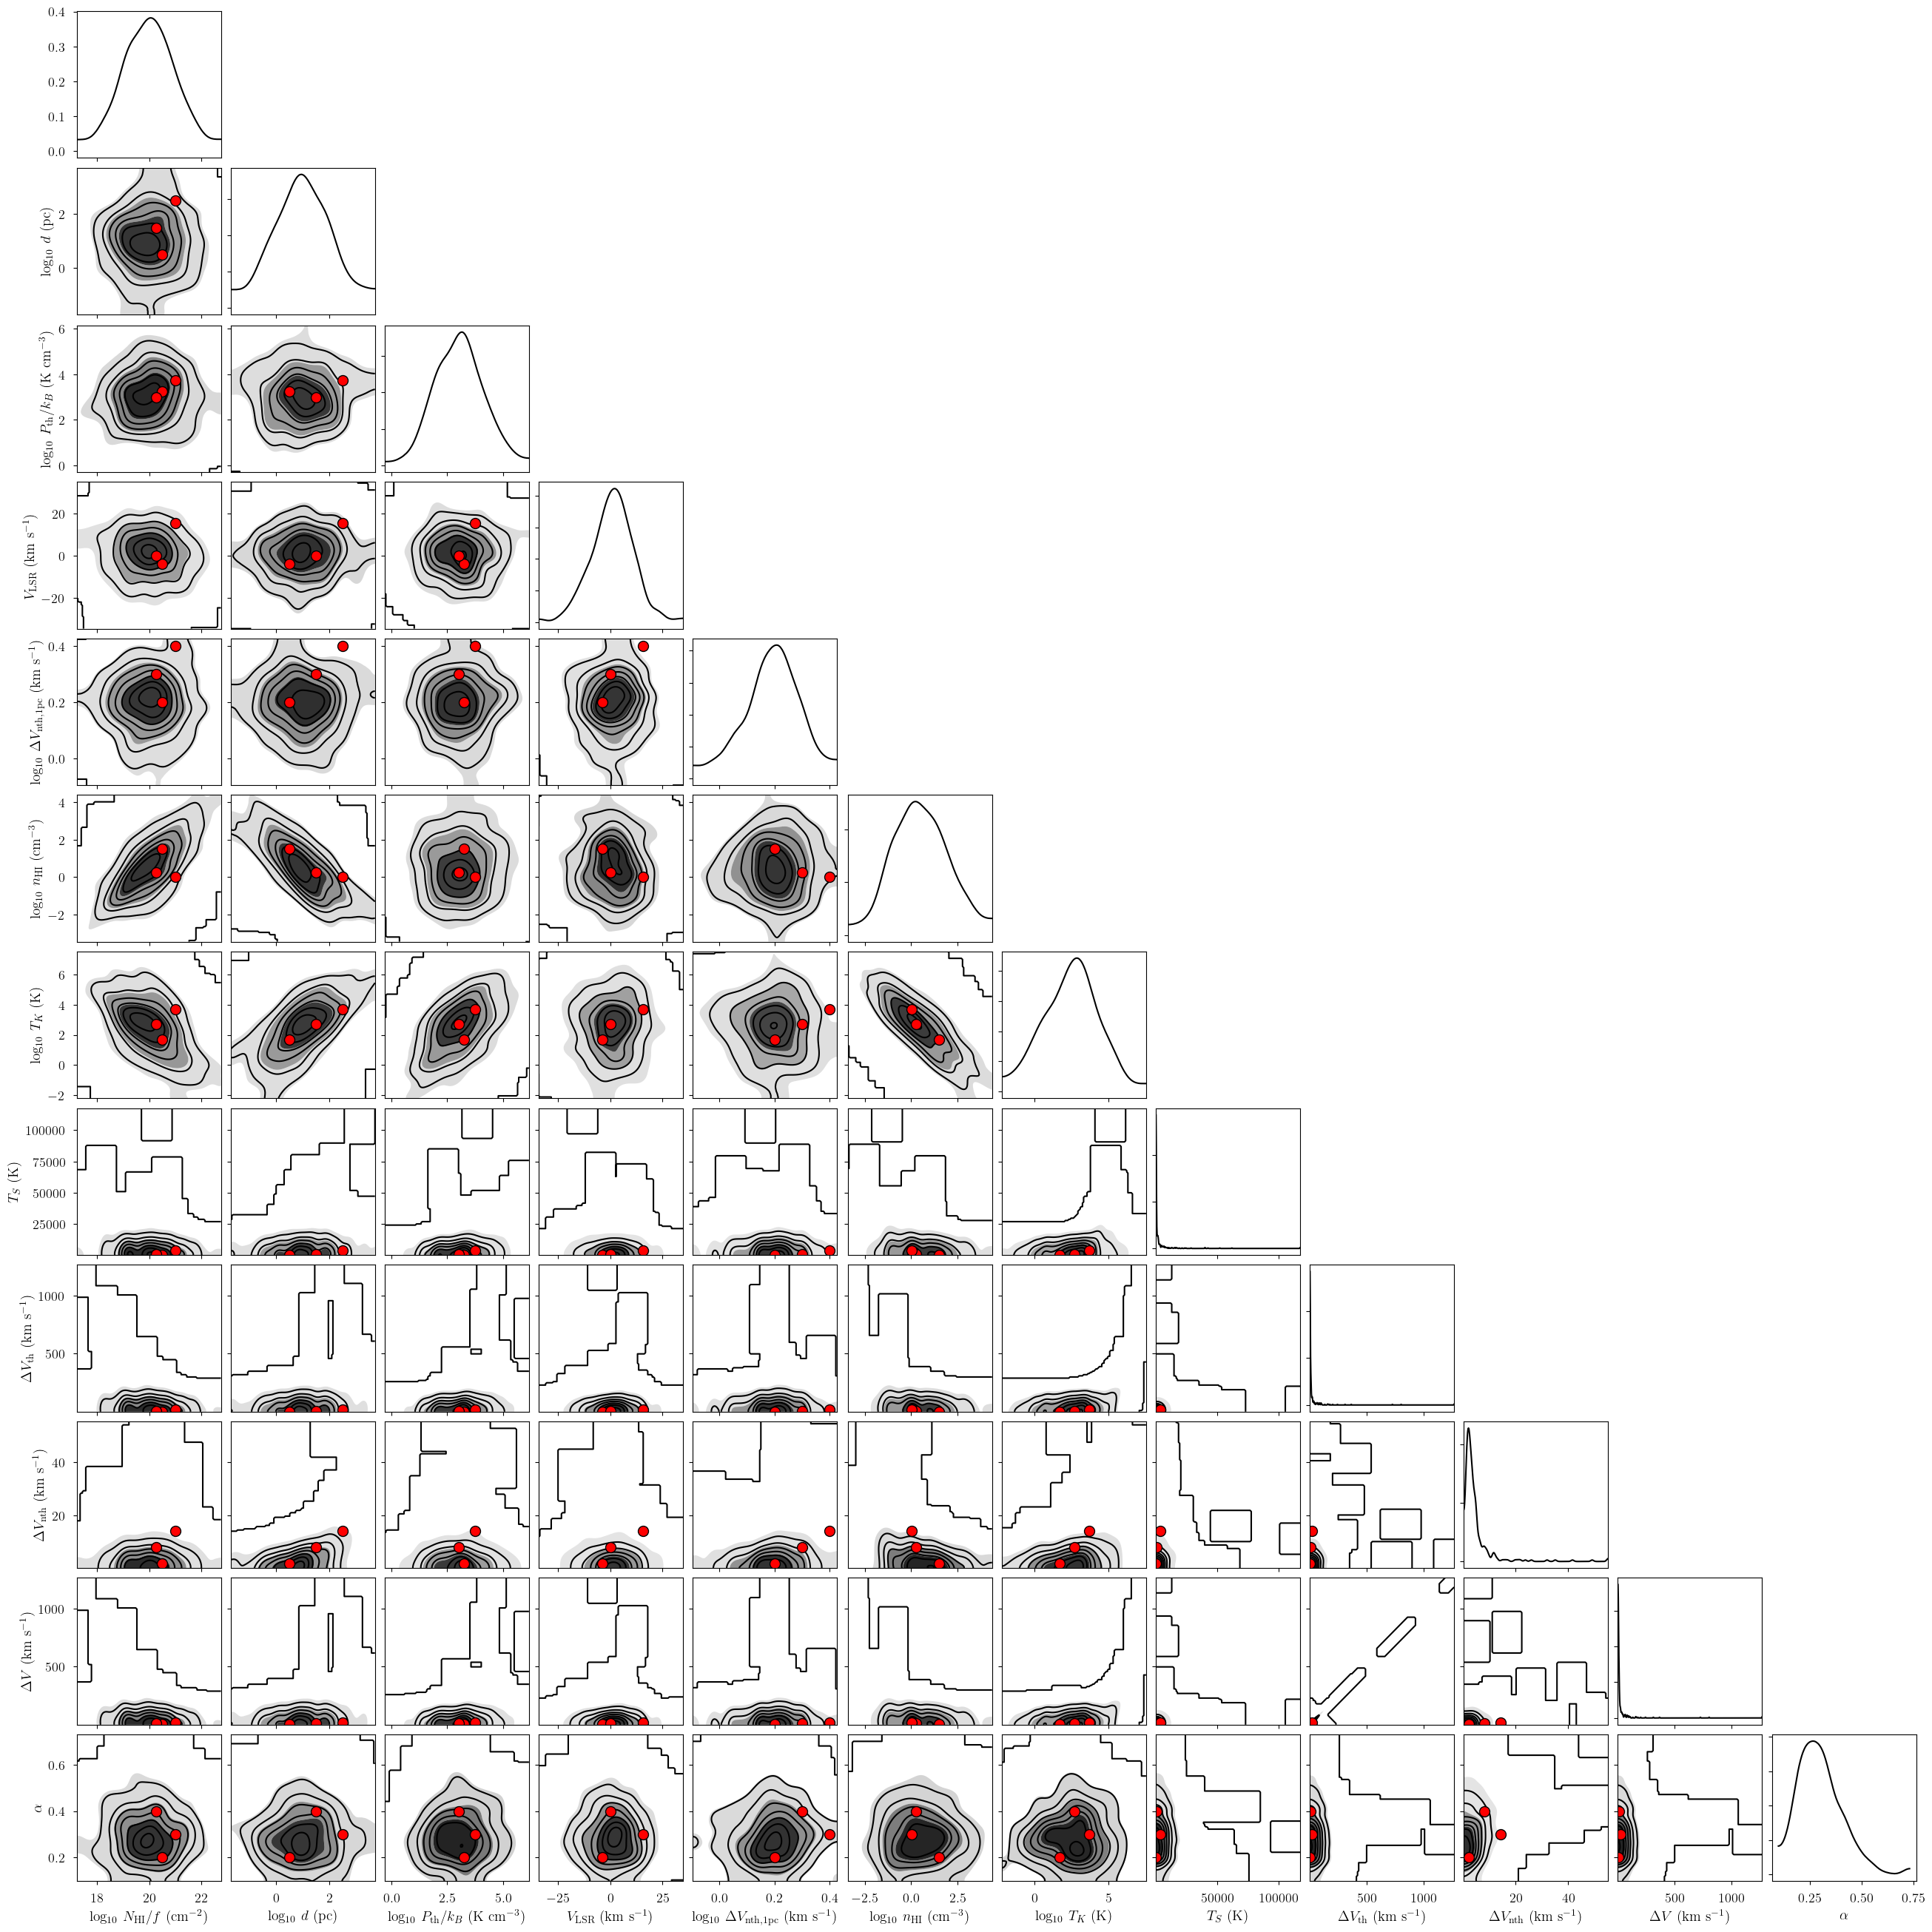

In [12]:
from bayes_spec.plots import plot_pair

_ = plot_pair(
    prior.prior, # samples
    model.cloud_deterministics + ["depth_nth_fwhm_power"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [41]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.03, # VI relative convergence threshold
    abs_tolerance = 0.03, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Finished [100%]: Average Loss = -41.074


Output()

Runtime: 0.36 minutes


In [14]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean      sd   hdi_3%  hdi_97%  mcse_mean  \
baseline_emission_norm[0]    -0.450   0.077   -0.595   -0.316      0.003   
log10_NHI_norm[0]             0.488   0.009    0.470    0.506      0.000   
log10_NHI_norm[1]             1.005   0.001    1.004    1.007      0.000   
log10_NHI_norm[2]             0.263   0.002    0.260    0.267      0.000   
log10_depth_norm[0]          -0.382   0.002   -0.385   -0.379      0.000   
log10_depth_norm[1]           0.913   0.001    0.911    0.915      0.000   
log10_depth_norm[2]           0.891   0.008    0.877    0.906      0.000   
log10_pressure_norm[0]        0.139   0.002    0.136    0.142      0.000   
log10_pressure_norm[1]        0.443   0.022    0.404    0.486      0.001   
log10_pressure_norm[2]       -0.792   0.057   -0.893   -0.684      0.002   
velocity_norm[0]             -0.405   0.001   -0.406   -0.404      0.000   
velocity_norm[1]              1.557   0.001    1.554    1.559      0.000   
velocity_norm[2]             -0.011   0.003   -0.017   -0.006      0.000   
log10_n_alpha_norm            0.017   1.021   -1.847    1.960      0.033   
log10_nth_fwhm_1pc_norm[0]   -0.471   0.031   -0.524   -0.413      0.001   
log10_nth_fwhm_1pc_norm[1]    1.938   0.006    1.926    1.950      0.000   
log10_nth_fwhm_1pc_norm[2]    0.957   0.029    0.902    1.008      0.001   
depth_nth_fwhm_power[0]       0.243   0.005    0.235    0.252      0.000   
depth_nth_fwhm_power[1]       0.475   0.000    0.475    0.476      0.000   
depth_nth_fwhm_power[2]       0.339   0.002    0.336    0.342      0.000   
log10_NHI[0]                 20.488   0.009   20.470   20.506      0.000   
log10_NHI[1]                 21.005   0.001   21.004   21.007      0.000   
log10_NHI[2]                 20.263   0.002   20.260   20.267      0.000   
log10_depth[0]                0.618   0.002    0.615    0.621      0.000   
log10_depth[1]                1.913   0.001    1.911    1.915      0.000   
log10_depth[2]                1.891   0.008    1.877    1.906      0.000   
log10_pressure[0]             3.139   0.002    3.136    3.142      0.000   
log10_pressure[1]             3.443   0.022    3.404    3.486      0.001   
log10_pressure[2]             2.208   0.057    2.107    2.316      0.002   
velocity[0]                  -4.047   0.006   -4.058   -4.037      0.000   
velocity[1]                  15.566   0.013   15.542   15.592      0.000   
velocity[2]                  -0.114   0.029   -0.165   -0.061      0.001   
log10_n_alpha                -5.983   1.021   -7.847   -4.040      0.033   
log10_nth_fwhm_1pc[0]         0.153   0.003    0.148    0.159      0.000   
log10_nth_fwhm_1pc[1]         0.394   0.001    0.393    0.395      0.000   
log10_nth_fwhm_1pc[2]         0.296   0.003    0.290    0.301      0.000   
log10_nHI[0]                  1.381   0.010    1.361    1.398      0.000   
log10_nHI[1]                  0.603   0.001    0.601    0.606      0.000   
log10_nHI[2]                 -0.117   0.008   -0.131   -0.100      0.000   
log10_tkin[0]                 1.717   0.010    1.697    1.735      0.000   
log10_tkin[1]                 2.798   0.022    2.756    2.838      0.001   
log10_tkin[2]                 2.284   0.057    2.175    2.386      0.002   
tspin[0]                     52.062   1.182   49.808   54.302      0.036   
tspin[1]                    621.099  31.008  564.404  683.319      1.007   
tspin[2]                    191.772  25.175  144.845  236.546      0.860   
fwhm_thermal[0]               1.544   0.018    1.510    1.576      0.001   
fwhm_thermal[1]               5.361   0.133    5.108    5.616      0.004   
fwhm_thermal[2]               2.972   0.196    2.615    3.334      0.007   
fwhm_nonthermal[0]            2.010   0.019    1.975    2.044      0.001   
fwhm_nonthermal[1]           20.093   0.050   19.997   20.186      0.002   
fwhm_nonthermal[2]            8.628   0.098    8.442    8.813      0.003   
fwhm[0]                       2.534   0.018    2.498    2.566      0.001   
fwh

Sampling: [emission]


Output()

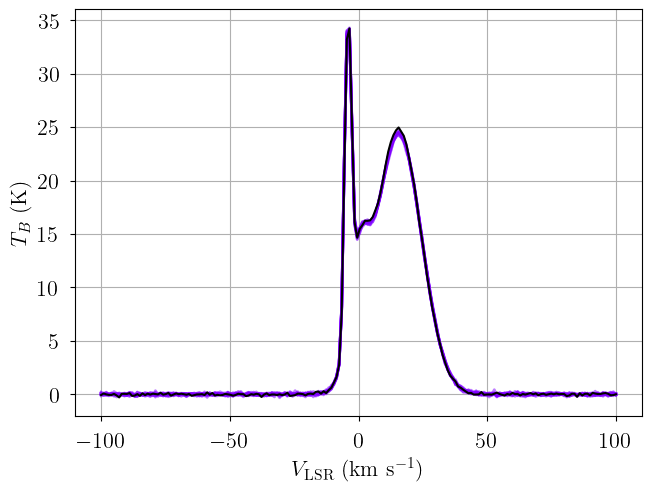

In [15]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [16]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.02,
        "abs_tolerance": 0.01,
        "learning_rate": 0.01,
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = -41.074
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_emission_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_nth_fwhm_1pc_norm, depth_nth_fwhm_power]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 261 seconds.


Adding log-likelihood to trace


Output()

Runtime: 4.84 minutes


In [17]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`). Note that this model does not appear fully converged: the r-hat statistics for some parameters are approaching `1.05`, but the effective sample sizes are all >100. Running longer chains (drawing more samples) would help.

In [18]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean        sd    hdi_3%   hdi_97%  mcse_mean  \
baseline_emission_norm[0]     -0.467     0.081    -0.615    -0.309      0.002   
log10_NHI_norm[0]              0.497     0.014     0.472     0.522      0.000   
log10_NHI_norm[1]              1.001     0.002     0.998     1.004      0.000   
log10_NHI_norm[2]              0.252     0.017     0.230     0.273      0.002   
log10_depth_norm[0]           -0.526     0.381    -1.210     0.193      0.017   
log10_depth_norm[1]            1.242     0.627     0.040     2.435      0.019   
log10_depth_norm[2]            0.520     0.600    -0.584     1.702      0.018   
log10_pressure_norm[0]         0.277     0.381    -0.440     0.961      0.017   
log10_pressure_norm[1]         1.093     0.754    -0.358     2.462      0.026   
log10_pressure_norm[2]         0.230     0.830    -1.433     1.656      0.034   
velocity_norm[0]              -0.400     0.001    -0.401    -0.399      0.000   
velocity_norm[1]               1.552     0.003     1.547     1.557      0.000   
velocity_norm[2]              -0.008     0.006    -0.019     0.002      0.000   
log10_n_alpha_norm             0.004     0.997    -1.863     1.866      0.022   
log10_nth_fwhm_1pc_norm[0]    -0.185     0.862    -1.838     1.355      0.036   
log10_nth_fwhm_1pc_norm[1]     0.054     0.994    -1.756     1.985      0.022   
log10_nth_fwhm_1pc_norm[2]     0.110     1.038    -1.794     2.140      0.025   
depth_nth_fwhm_power[0]        0.269     0.092     0.104     0.436      0.003   
depth_nth_fwhm_power[1]        0.309     0.097     0.134     0.483      0.003   
depth_nth_fwhm_power[2]        0.312     0.097     0.137     0.490      0.003   
log10_NHI[0]                  20.497     0.014    20.472    20.522      0.000   
log10_NHI[1]                  21.001     0.002    20.998    21.004      0.000   
log10_NHI[2]                  20.252     0.017    20.230    20.273      0.002   
log10_depth[0]                 0.474     0.381    -0.210     1.193      0.017   
log10_depth[1]                 2.242     0.627     1.040     3.435      0.019   
log10_depth[2]                 1.520     0.600     0.416     2.702      0.018   
log10_pressure[0]              3.277     0.381     2.560     3.961      0.017   
log10_pressure[1]              4.093     0.754     2.642     5.462      0.026   
log10_pressure[2]              3.230     0.830     1.567     4.656      0.034   
velocity[0]                   -4.000     0.006    -4.011    -3.989      0.000   
velocity[1]                   15.522     0.027    15.470    15.573      0.001   
velocity[2]                   -0.084     0.057    -0.192     0.022      0.003   
log10_n_alpha                 -5.996     0.997    -7.863    -4.134      0.022   
log10_nth_fwhm_1pc[0]          0.181     0.086     0.016     0.335      0.004   
log10_nth_fwhm_1pc[1]          0.205     0.099     0.024     0.399      0.002   
log10_nth_fwhm_1pc[2]          0.211     0.104     0.021     0.414      0.003   
log10_nHI[0]                   1.533     0.382     0.812     2.216      0.017   
log10_nHI[1]                   0.269     0.627    -0.910     1.484      0.019   
log10_nHI[2]                   0.242     0.598    -0.870     1.408      0.018   
log10_tkin[0]                  1.703     0.014     1.678     1.728      0.000   
log10_tkin[1]                  3.783     0.259     3.216     3.973      0.011   
log10_tkin[2]                  2.946     0.395     2.102     3.285      0.028   
tspin[0]                      50.469     1.592    47.564    53.413      0.045   
tspin[1]                    5724.566  2435.046  1270.118  9161.215     89.051   
tspin[2]                    1101.077   554.380    90.632  1814.358     24.969   
fwhm_thermal[0]                1.520     0.024     1.476     1.565      0.001   
fwhm_thermal[1]               17.278     3.940     8.674    20.741      0.153   
fwhm_thermal[2]                6.893     2.224     2.326     9.248      0.120   
fwhm_nonthermal[0]             1.981     0.027     1.928     2.

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [emission]


Output()

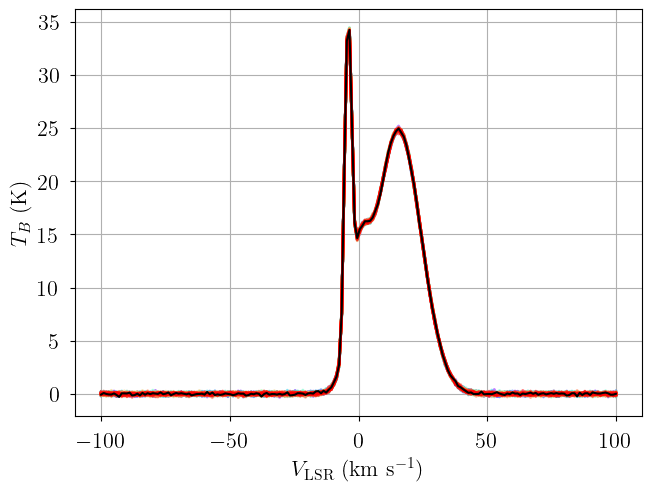

In [19]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

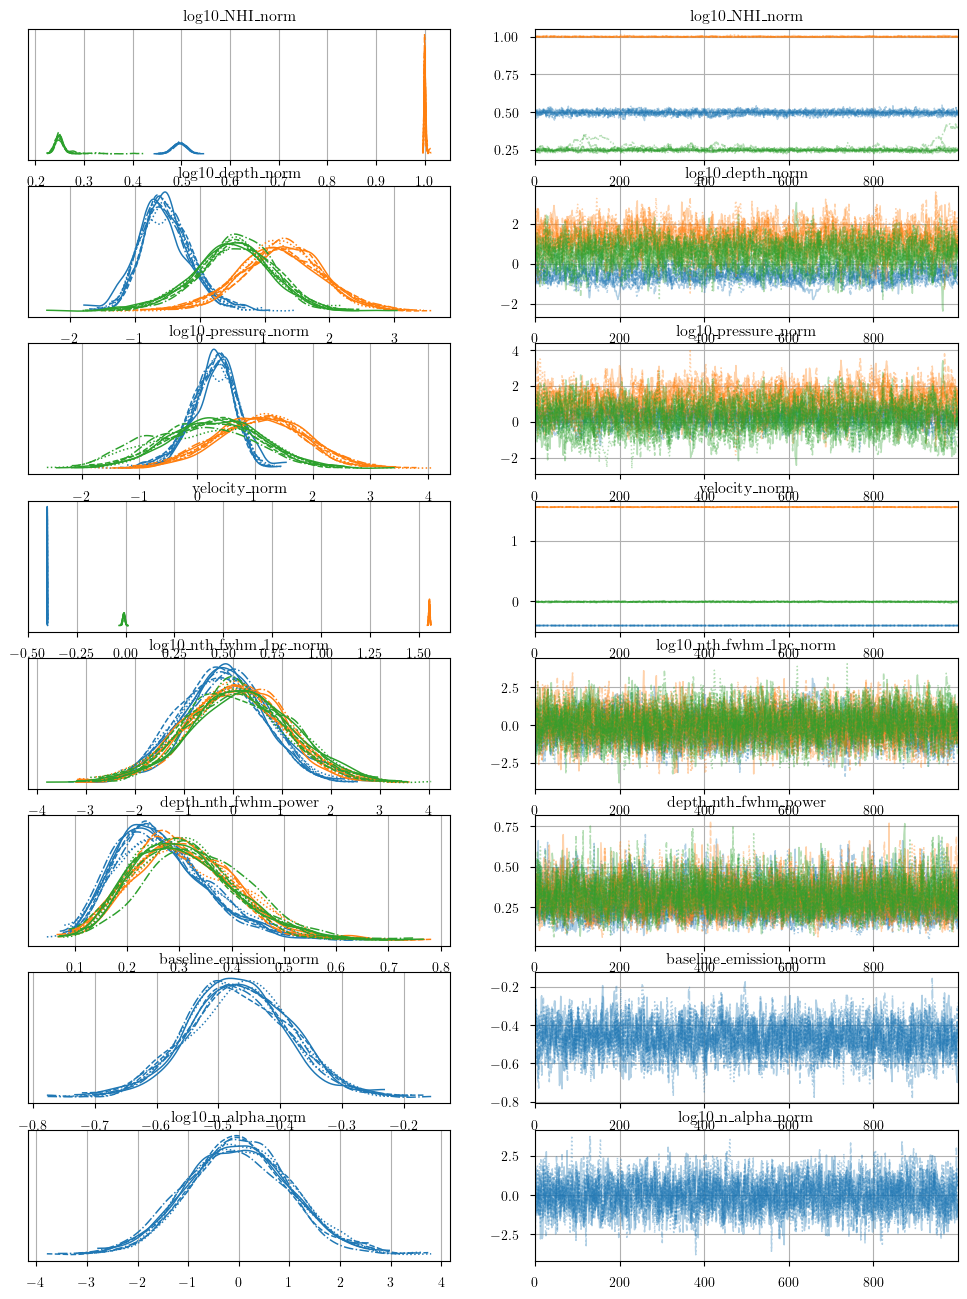

In [20]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. The red points represent the simulation parameters.

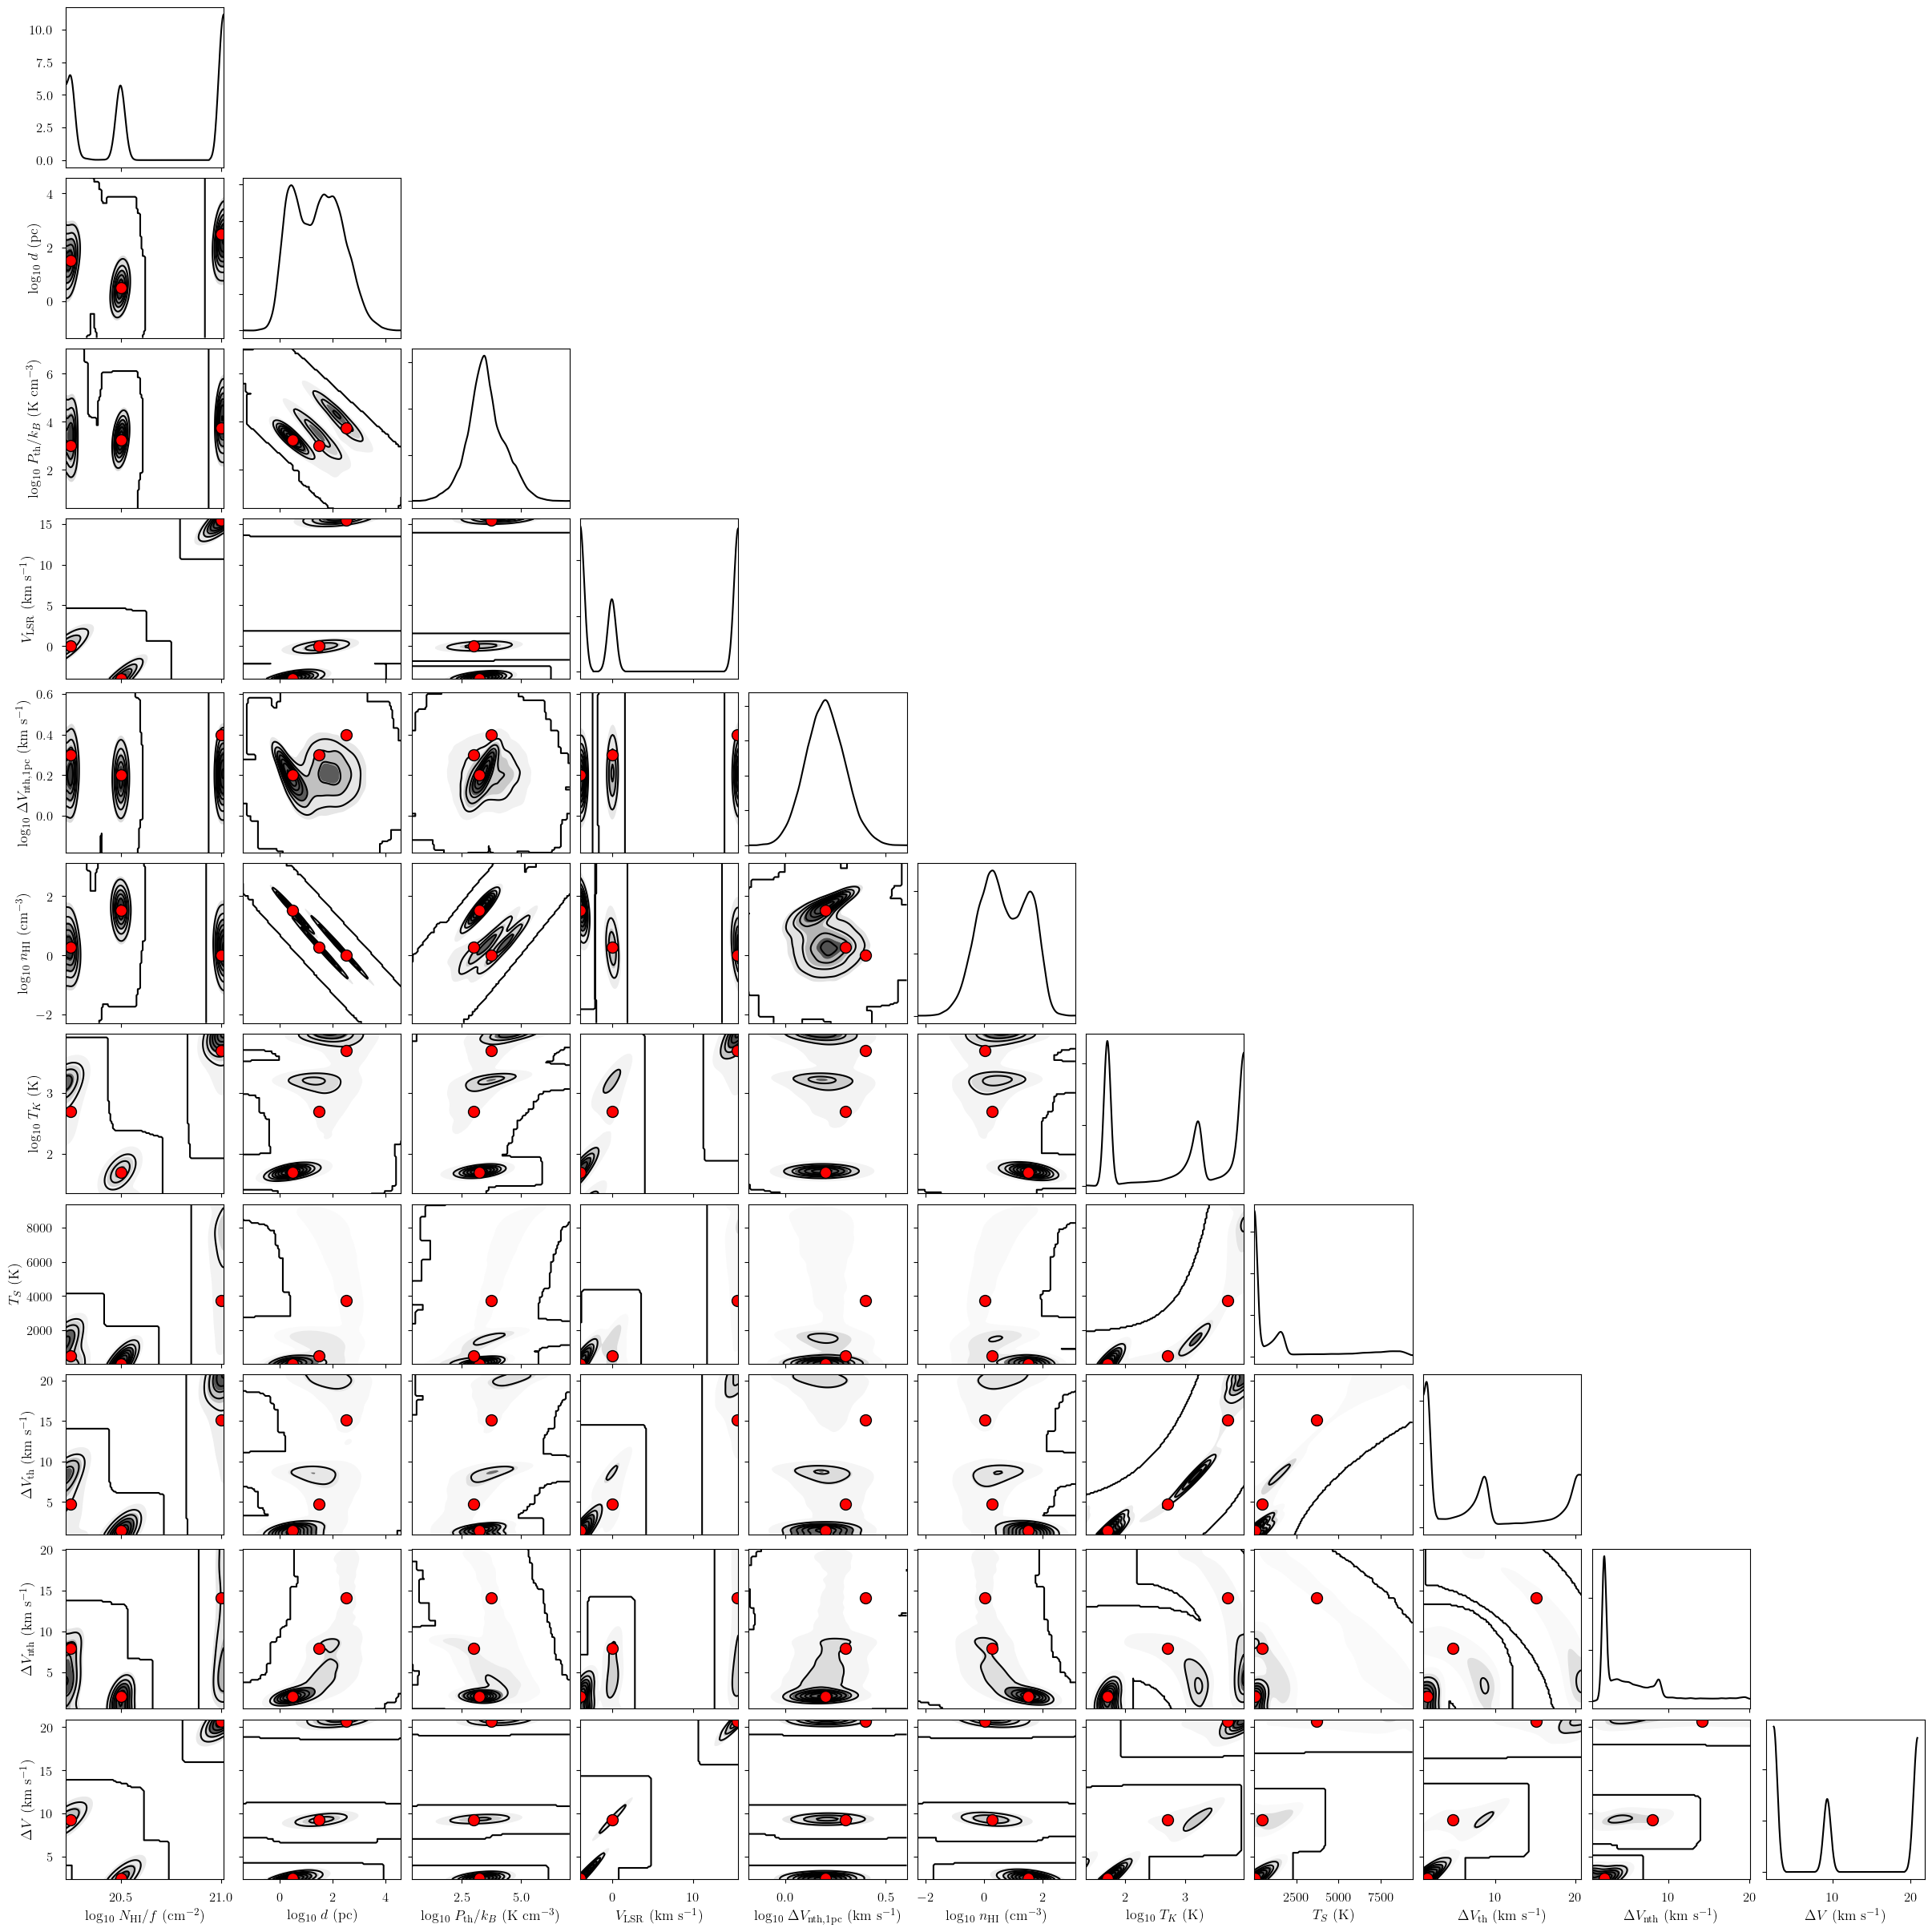

In [21]:
_ = plot_pair(
    model.trace.solution_0, # samples
    model.cloud_deterministics, # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud. This model is difficult to constrain with emission-only data due to the strong degeneracies.

In [22]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(2), 2: np.int64(1)}

In [23]:
print("cloud freeRVs", model.cloud_freeRVs)
print("cloud deterministics", model.cloud_deterministics)
print("hyper freeRVs", model.hyper_freeRVs)
print("hyper deterministics", model.hyper_deterministics)

cloud freeRVs ['log10_NHI_norm', 'log10_depth_norm', 'log10_pressure_norm', 'velocity_norm', 'log10_nth_fwhm_1pc_norm', 'depth_nth_fwhm_power']
cloud deterministics ['log10_NHI', 'log10_depth', 'log10_pressure', 'velocity', 'log10_nth_fwhm_1pc', 'log10_nHI', 'log10_tkin', 'tspin', 'fwhm_thermal', 'fwhm_nonthermal', 'fwhm']
hyper freeRVs ['log10_n_alpha_norm']
hyper deterministics ['log10_n_alpha']


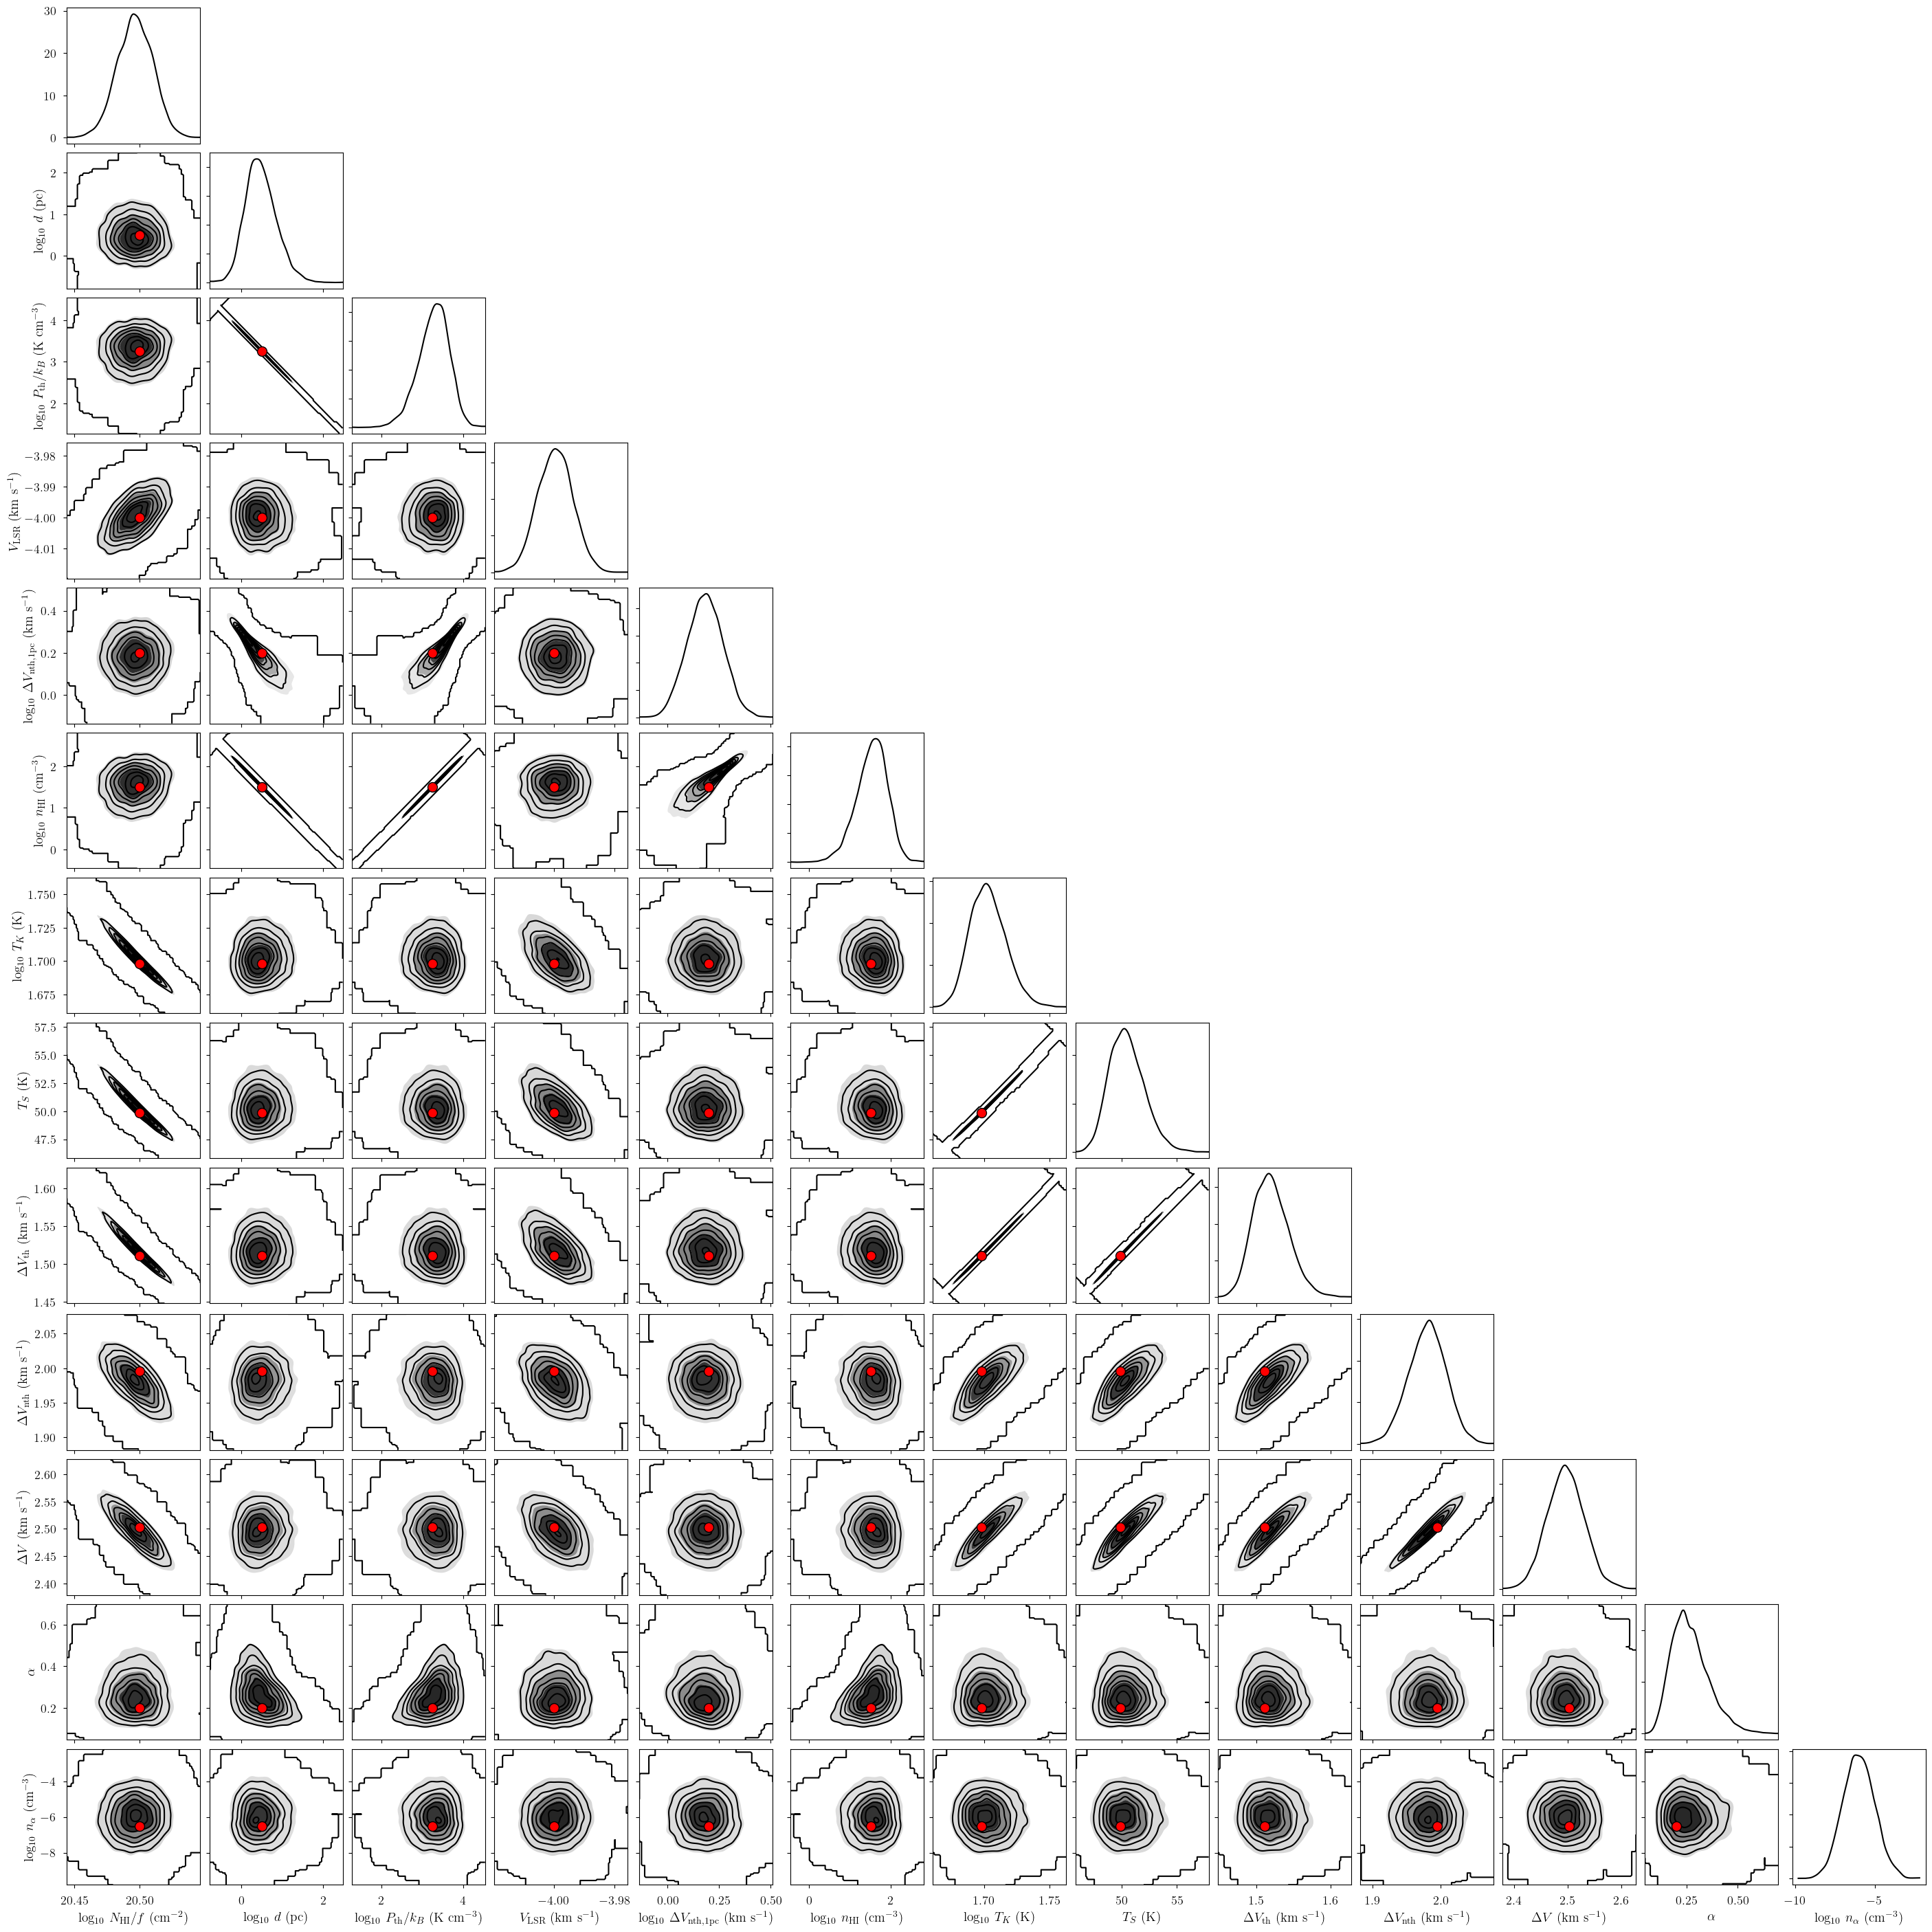

In [34]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ['depth_nth_fwhm_power']:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    list(my_sim_params.keys()), # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

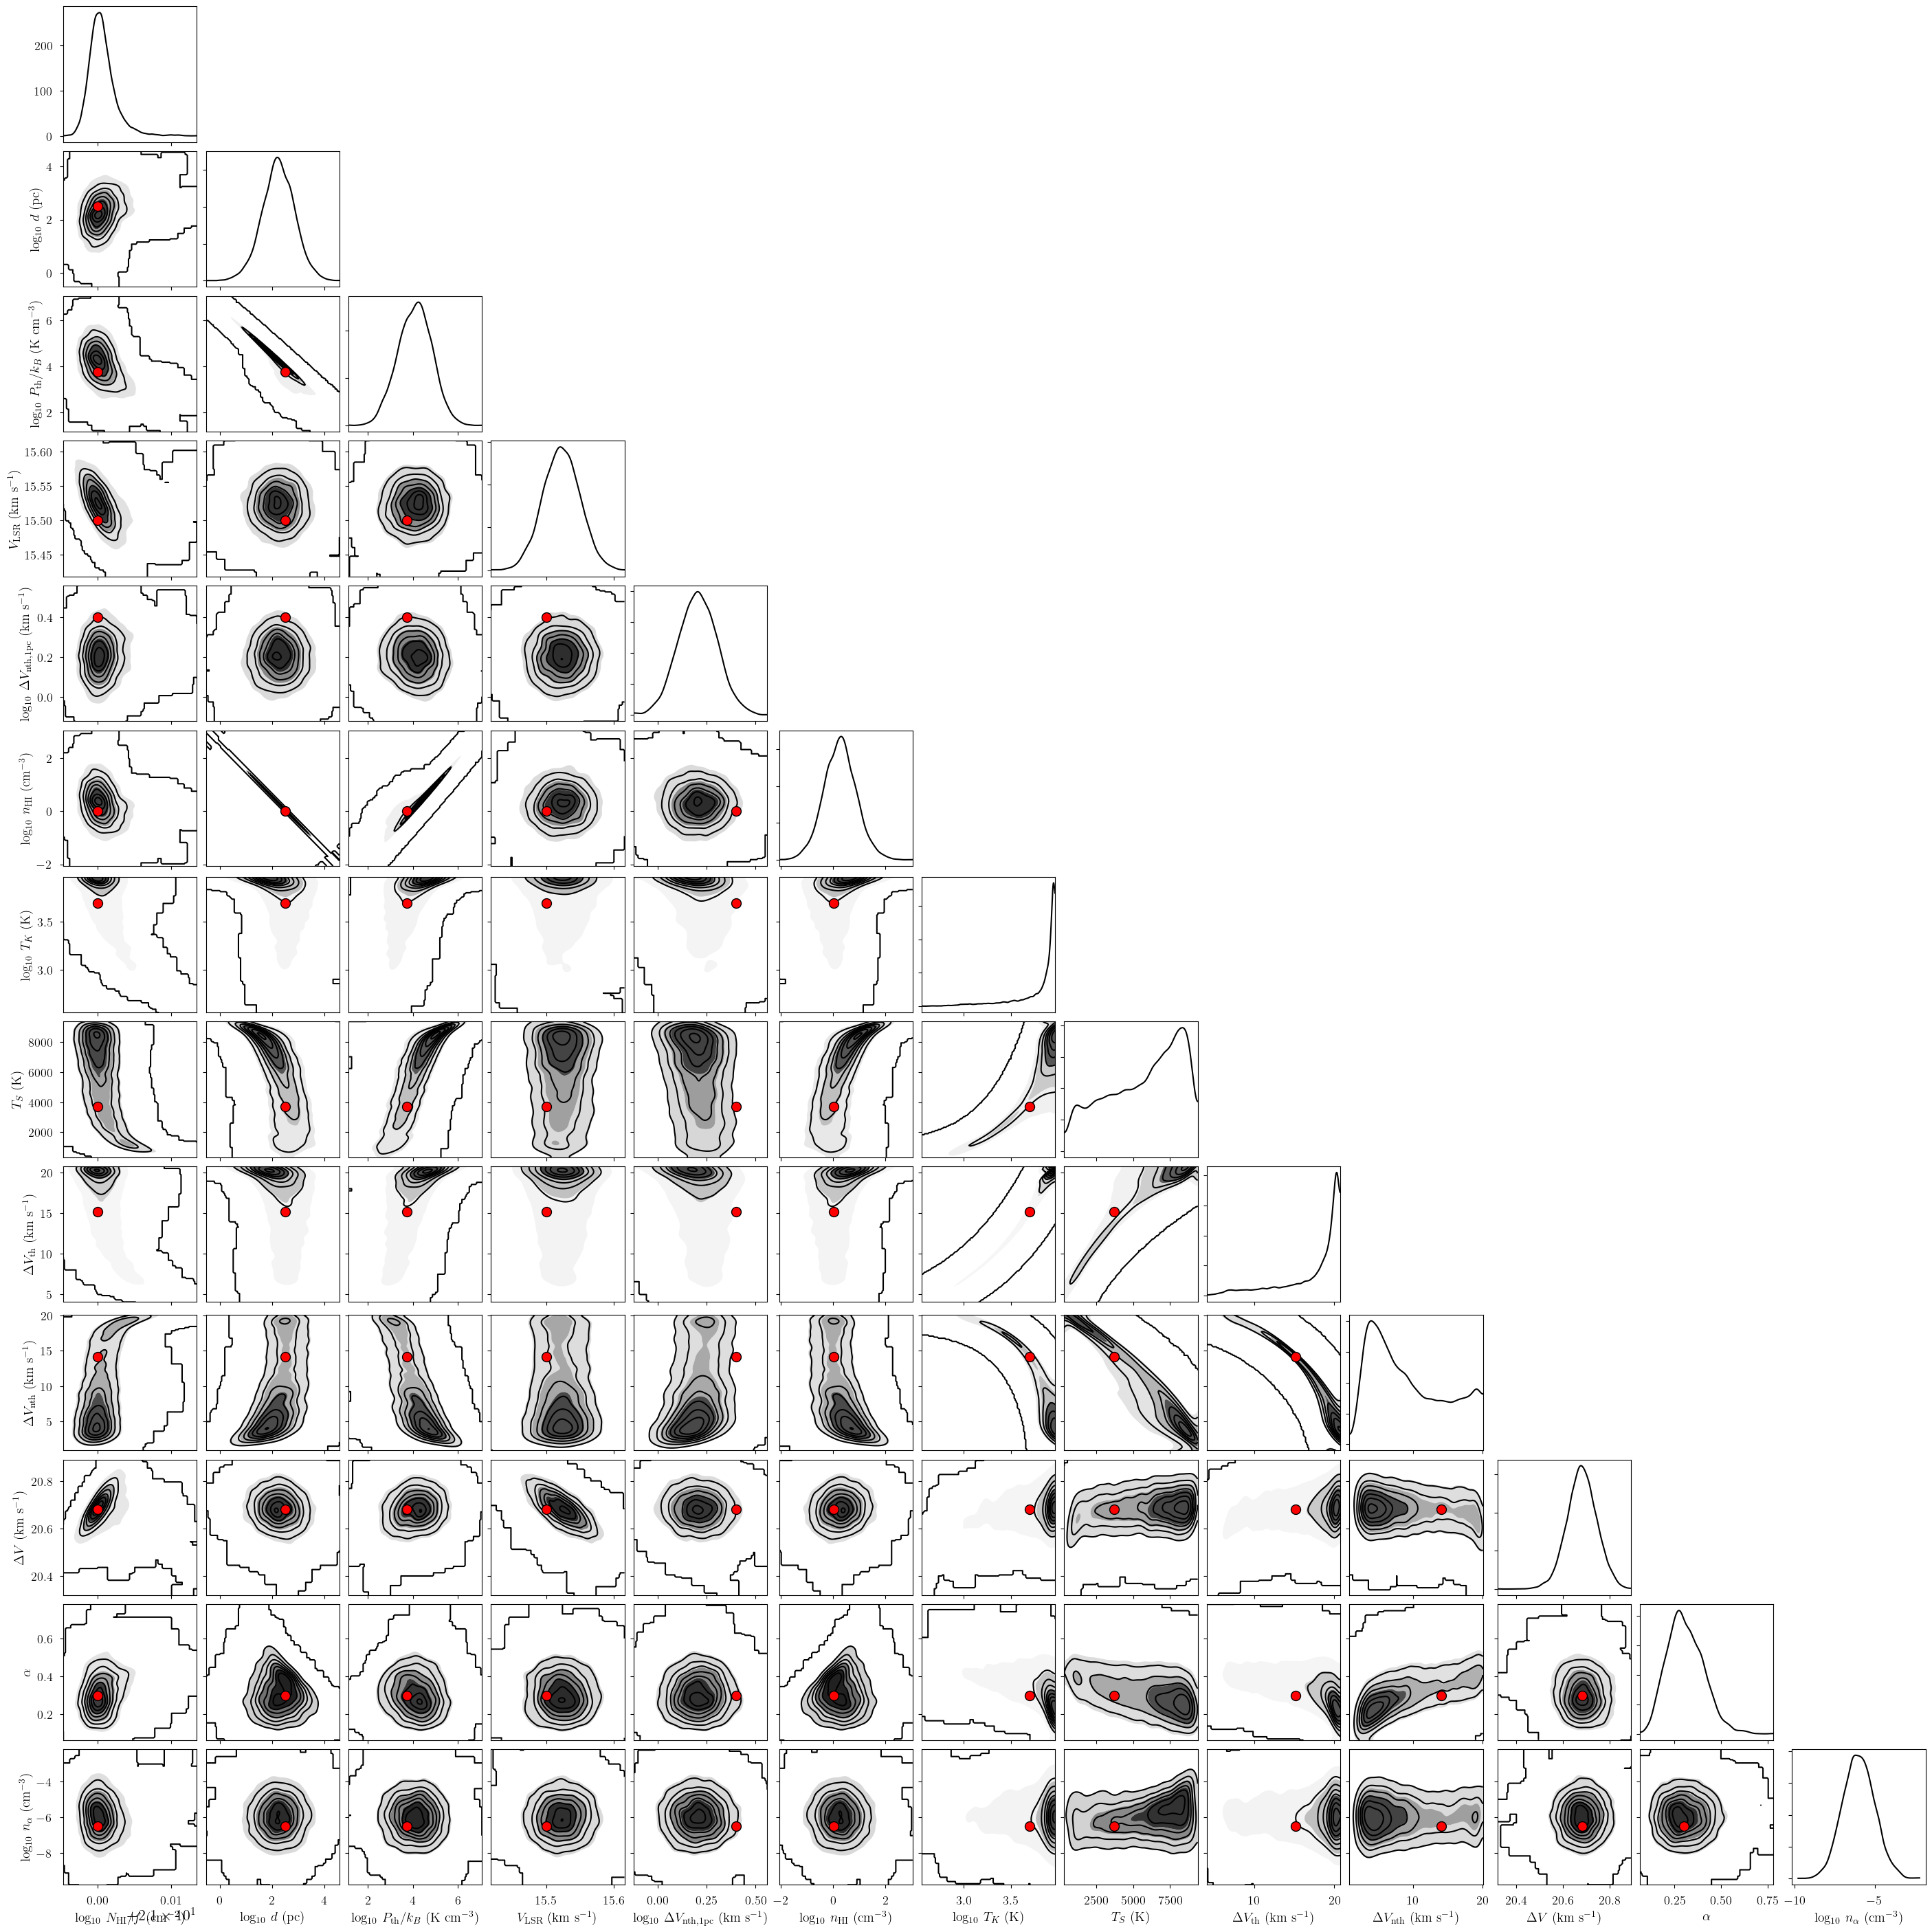

In [33]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ['depth_nth_fwhm_power']:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    list(my_sim_params.keys()), # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

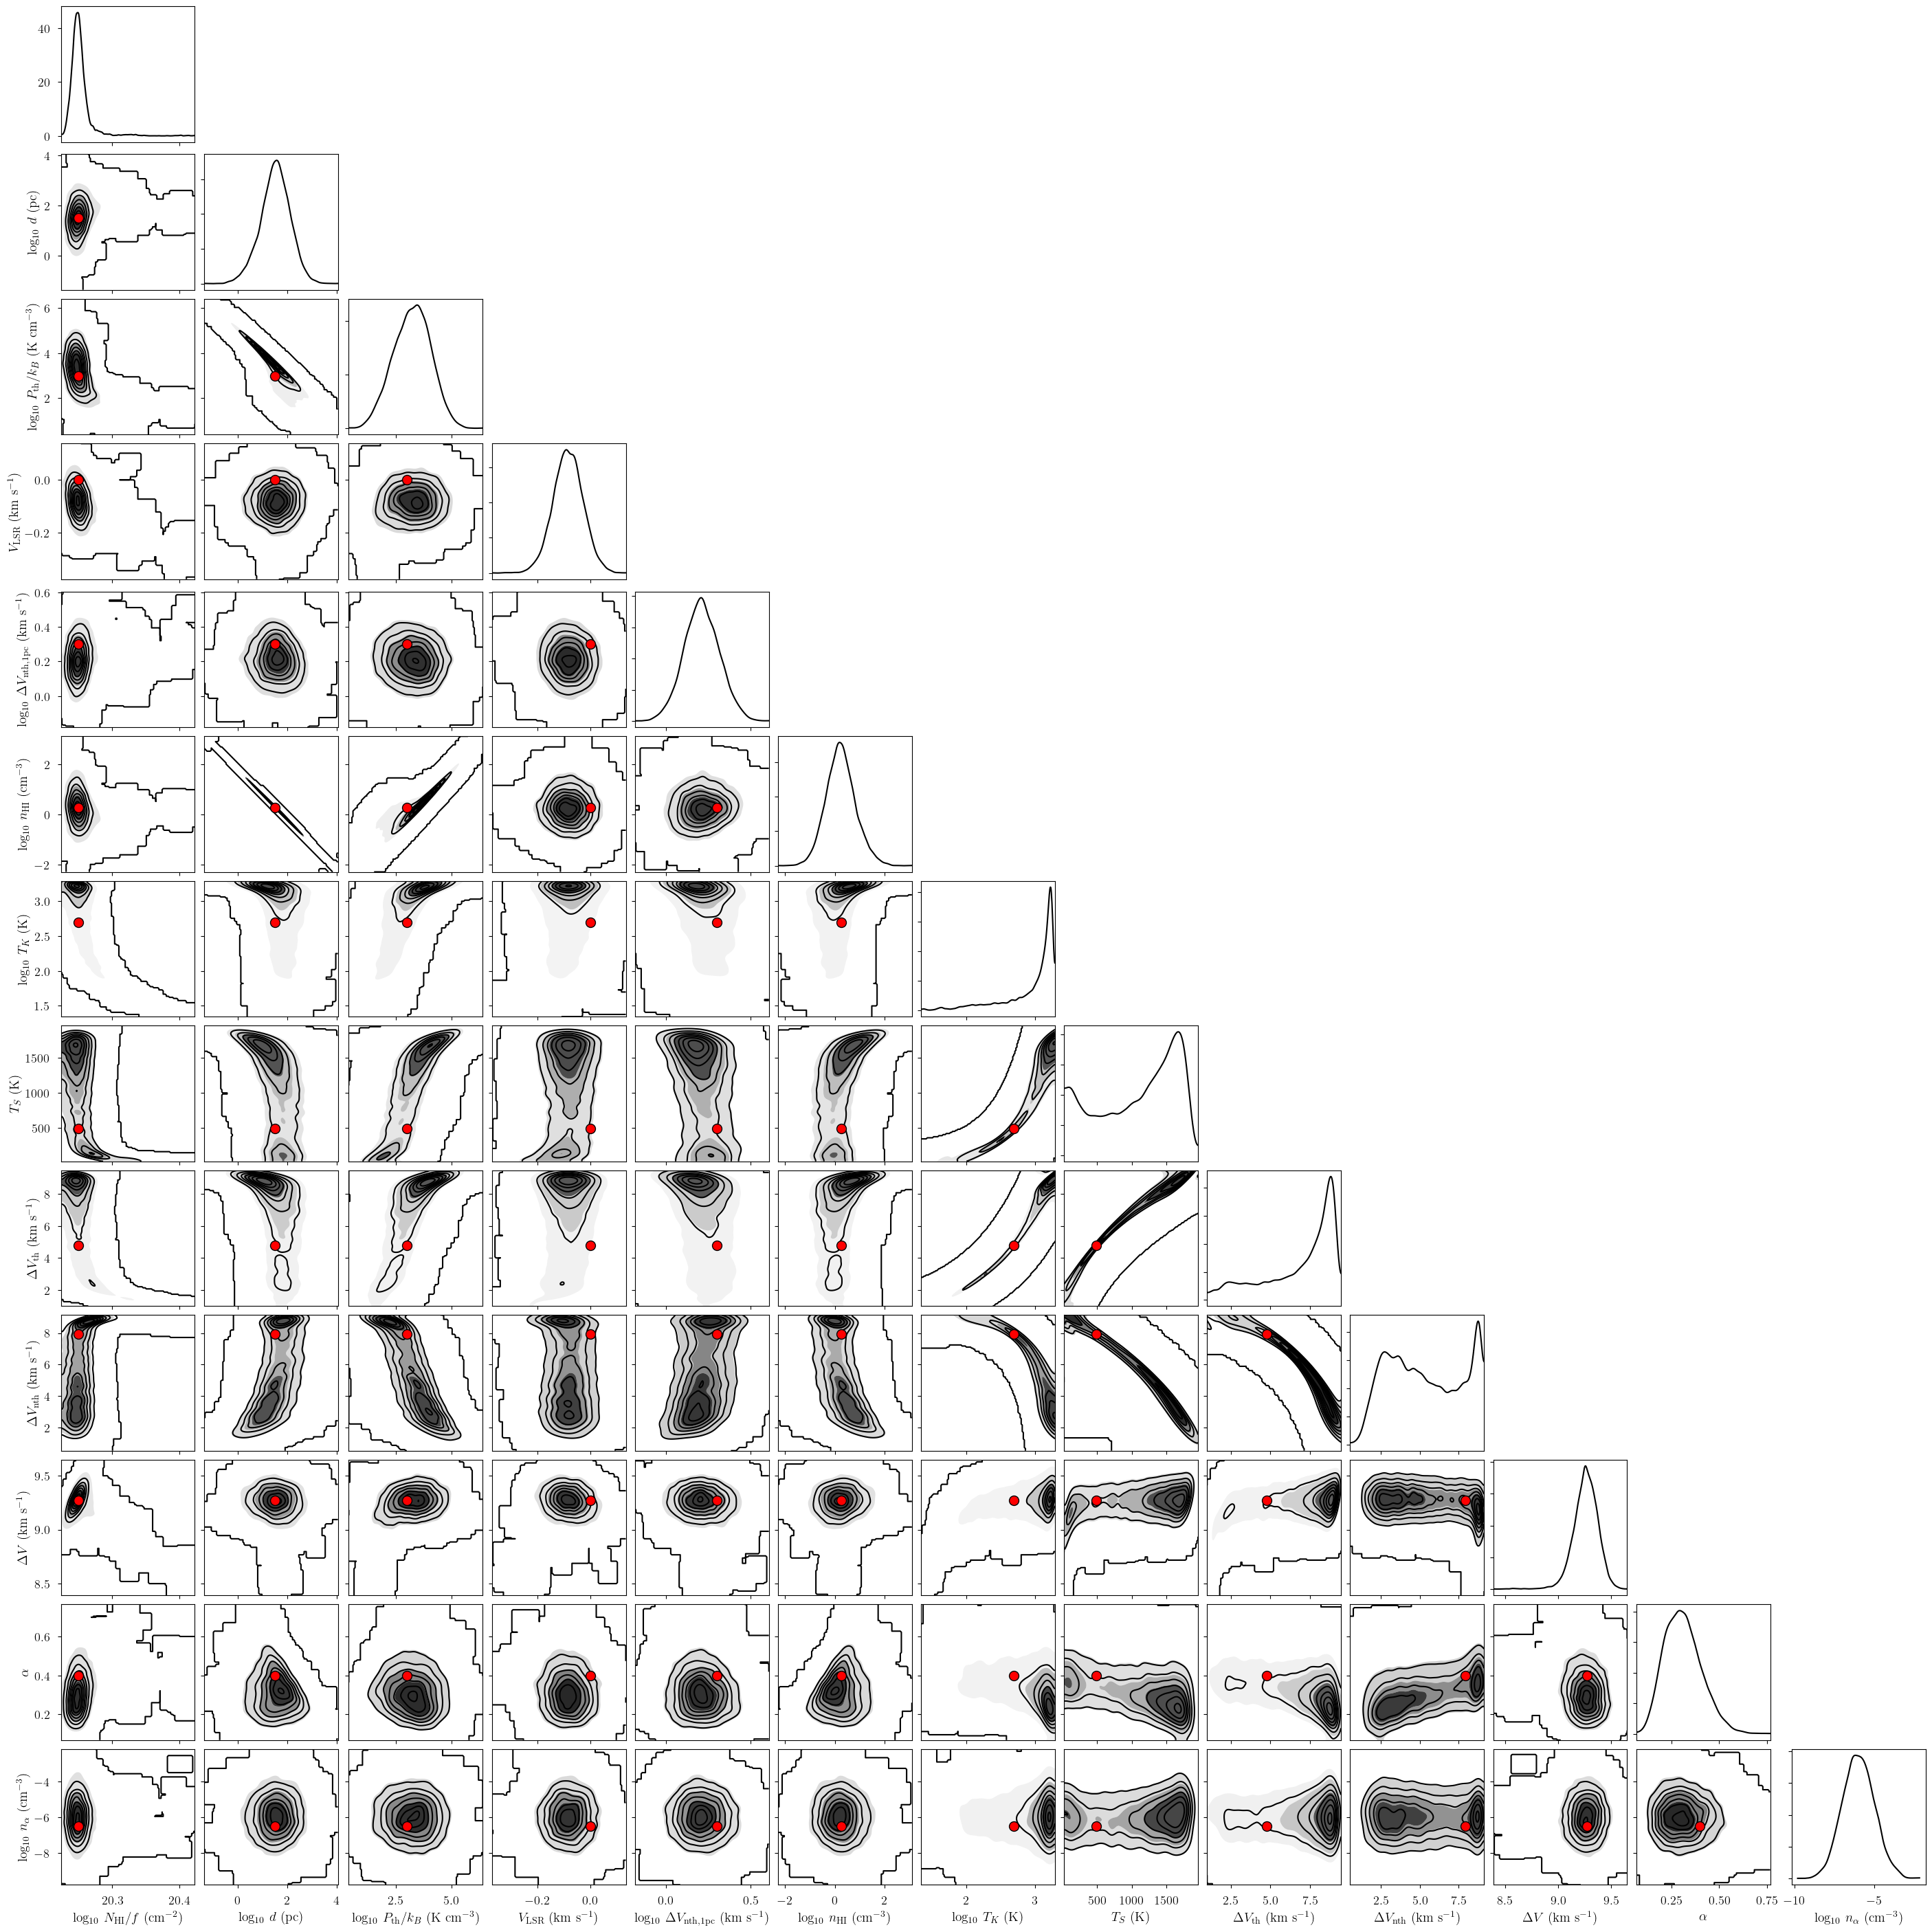

In [35]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ['depth_nth_fwhm_power']:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    list(my_sim_params.keys()), # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [31]:
point_stats = az.summary(model.trace.solution_0, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -285.54355244684376


mean        sd   hdi_16%   hdi_84%
baseline_emission_norm[0]     -0.467     0.081    -0.548    -0.388
log10_NHI_norm[0]              0.497     0.014     0.483     0.510
log10_NHI_norm[1]              1.001     0.002     0.999     1.002
log10_NHI_norm[2]              0.252     0.017     0.239     0.257
log10_depth_norm[0]           -0.526     0.381    -0.957    -0.227
log10_depth_norm[1]            1.242     0.627     0.654     1.865
log10_depth_norm[2]            0.520     0.600    -0.030     1.113
log10_pressure_norm[0]         0.277     0.381    -0.021     0.708
log10_pressure_norm[1]         1.093     0.754     0.418     1.918
log10_pressure_norm[2]         0.230     0.830    -0.550     1.132
velocity_norm[0]              -0.400     0.001    -0.401    -0.399
velocity_norm[1]               1.552     0.003     1.550     1.555
velocity_norm[2]              -0.008     0.006    -0.014    -0.003
log10_n_alpha_norm             0.004     0.997    -1.009     0.982
log10_nth_fwhm_1pc_norm[0]    -0.185     0.862    -1.083     0.646
log10_nth_fwhm_1pc_norm[1]     0.054     0.994    -0.969     1.004
log10_nth_fwhm_1pc_norm[2]     0.110     1.038    -1.030     1.023
depth_nth_fwhm_power[0]        0.269     0.092     0.155     0.325
depth_nth_fwhm_power[1]        0.309     0.097     0.209     0.403
depth_nth_fwhm_power[2]        0.312     0.097     0.191     0.380
log10_NHI[0]                  20.497     0.014    20.483    20.510
log10_NHI[1]                  21.001     0.002    20.999    21.002
log10_NHI[2]                  20.252     0.017    20.239    20.257
log10_depth[0]                 0.474     0.381     0.043     0.773
log10_depth[1]                 2.242     0.627     1.654     2.865
log10_depth[2]                 1.520     0.600     0.970     2.113
log10_pressure[0]              3.277     0.381     2.979     3.708
log10_pressure[1]              4.093     0.754     3.418     4.918
log10_pressure[2]              3.230     0.830     2.450     4.132
velocity[0]                   -4.000     0.006    -4.006    -3.994
velocity[1]                   15.522     0.027    15.496    15.550
velocity[2]                   -0.084     0.057    -0.142    -0.031
log10_n_alpha                 -5.996     0.997    -7.009    -5.018
log10_nth_fwhm_1pc[0]          0.181     0.086     0.092     0.265
log10_nth_fwhm_1pc[1]          0.205     0.099     0.103     0.300
log10_nth_fwhm_1pc[2]          0.211     0.104     0.097     0.302
log10_nHI[0]                   1.533     0.382     1.205     1.938
log10_nHI[1]                   0.269     0.627    -0.342     0.868
log10_nHI[2]                   0.242     0.598    -0.351     0.784
log10_tkin[0]                  1.703     0.014     1.688     1.715
log10_tkin[1]                  3.783     0.259     3.808     3.973
log10_tkin[2]                  2.946     0.395     2.950     3.277
tspin[0]                      50.469     1.592    48.606    51.697
tspin[1]                    5724.566  2435.046  4434.564  9161.474
tspin[2]                    1101.077   554.380   824.079  1847.289
fwhm_thermal[0]                1.520     0.024     1.494     1.540
fwhm_thermal[1]               17.278     3.940    17.153    20.729
fwhm_thermal[2]                6.893     2.224     6.341     9.248
fwhm_nonthermal[0]             1.981     0.027     1.956     2.010
fwhm_nonthermal[1]             9.272     5.263     2.113    11.956
fwhm_nonthermal[2]             5.285     2.304     1.825     7.065
fwhm[0]                        2.497     0.034     2.465     2.533
fwhm[1]                       20.681     0.064    20.621    20.745
fwhm[2]                        9.256     0.119     9.165     9.376